# QAOA for the Vertex Cover

In this section, we will solve the Vertex Cover Problem using QAOA with the help of the `JijModeling` and `Qamomile` libraries.

First, let's install and import the main libraries we will be using.


In [1]:
# !pip install qamomile[qiskit,quri-parts]
# !pip install pylatexenc

In [2]:
import qamomile.core as qm
import jijmodeling as jm
import ommx.v1
import networkx as nx
import matplotlib.pyplot as plt

## Formulation of the Vertex Cover Problem

Let's consider the formulation of the Vertex Cover Problem.

We define a binary variable $x_i$ such that $x_i = 1$ if vertex $i$ is included in $S$, and $x_i = 0$ otherwise. The objective function, which represents the size of $S$, can be expressed as follows.

$$
\sum_{i \in V} x_i
$$


The constraint is that all edges must be covered, meaning that for each edge, at least one of its endpoints must be included in $S$. This can be formulated as:

$$
x_{e_0} + x_{e_1} \geq 1 \quad \forall e \in E
$$


In summary, the Vertex Cover Problem can be formulated as follows:

$$
\begin{align}
&\min \sum_{i \in V} x_i \\
\text{s.t. } &x_{e_0} + x_{e_1} \geq 1 \quad \forall e \in E
\end{align}
$$

## Creating Problem Model using JijModeling

We describe the above formulation and then using JijModeling to create the problem model. `Placeholder` defines the values to be substituted as data, `BinaryVar` defines the decision variables, and `Element` defines the indices used in the summation. By checking the output, we can confirm that the formulation is correct.


In [24]:
def vertex_cover_problem() -> jm.Problem:
    # define variables
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    i = jm.Element("i", belong_to=(0, V))
    e = jm.Element("e", belong_to=E)

    # set problem
    problem = jm.Problem("Vertex Cover Problem")
    # ensure that at least one vertex of each edge is included in the cover
    # problem += jm.Constraint("cover", x[e[0]] + x[e[1]] >= 1, forall=e)
    # minimize the number of vertices included in the cover
    problem += jm.sum(i, x[i]) + jm.sum(e, (x[e[0]] + x[e[1] - 1.5]) ** 2) 
    return problem


problem = vertex_cover_problem()
problem

## Preparing Instance Data
Next, we will solve the Vertex Cover Problem for the following graph. The data for the specific problem being solved is referred to as instance data.


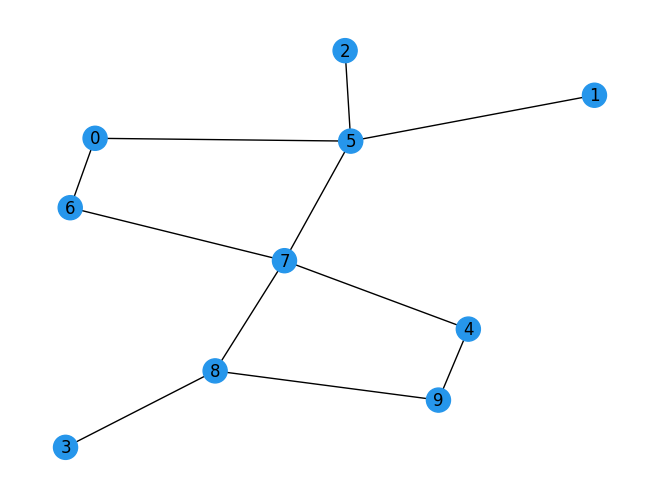

In [26]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
G.add_edges_from(
    [
        (0, 6),
        (0, 5),
        (1, 5),
        (2, 5),
        (3, 8),
        (4, 9),
        (4, 7),
        (5, 7),
        (6, 7),
        (7, 8),
        (8, 9),
    ]
)
positions = nx.spring_layout(G)
color = ["#2696EB"] * G.number_of_nodes()
nx.draw(G, node_color=color, pos=positions, with_labels=True)


## Creating a Compiled Instance

We perform compilation using the JijModeling-Transpiler by providing the formulation and the instance data prepared earlier. This process yields an intermediate representation of the problem with the instance data substituted.


In [27]:
inst_E = [list(edge) for edge in G.edges]
num_nodes = G.number_of_nodes()
instance_data = {"V": num_nodes, "E": inst_E}
num_qubits = num_nodes
compiled_instance = jm.Interpreter(instance_data).eval_problem(problem)

## Converting Compiled Instance to QAOA Circuit and Hamiltonian

We generate the QAOA circuit and Hamiltonian from the compiled Instance. The converter used to generate these is `qm.qaoa.QAOAConverter`.

By creating an instance of this class and using `ising_encode`, you can internally generate the Ising Hamiltonian from the compiled Instance. Parameters that arise during the conversion to QUBO can also be set here. If not set, default values are used.

Once the Ising Hamiltonian is generated, you can generate the QAOA quantum circuit and the Hamiltonian respectively. These can be executed using the `get_qaoa_ansatz` and `get_cost_hamiltonian` methods. The number of QAOA layers, $p$, is fixed to be $4$ here.   

In [28]:
qaoa_converter = qm.qaoa.QAOAConverter(compiled_instance)
# Encode to Ising Hamiltonian
qaoa_converter.ising_encode()
# Get the QAOA circuit
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=3)
# Get the cost Hamiltonian
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

## Visualization of QAOA Circuit
Qamomile provides a method to visualize the quantum circuit. You can use the `plot_quantum_circuit` function to visualize the QAOA quantum circuit.

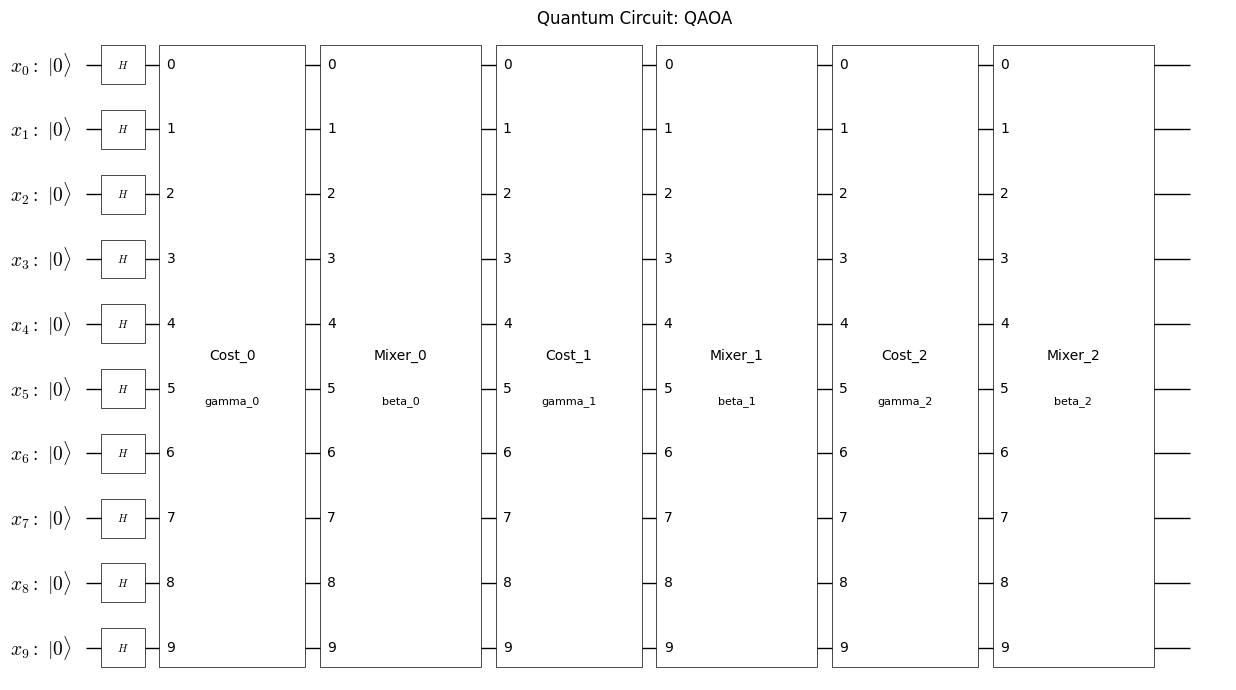

In [29]:
from qamomile.core.circuit.drawer import plot_quantum_circuit

plot_quantum_circuit(qaoa_circuit)

## Converting the Obtained QAOA Circuit and Hamiltonian for Qiskit

Here, we generate the Qiskit's QAOA circuit and Hamiltonian using the `qamomile.qiskit.QiskitTranspiler` converters. By utilizing the two methods,`QiskitTranspiler.transpile_circuit` and `QiskitTranspiler.transpile_hamiltonian`, we can transform the QAOA circuit and Hamiltonian into a format compatible with Qiskit. This allows us to leverage Qiskit's quantum computing framework to execute and analyze.

In [33]:
import qamomile.qiskit as qm_qk

qk_transpiler = qm_qk.QiskitTranspiler()
# Transpile the QAOA circuit to Qiskit
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
# Transpile the QAOA Hamiltonian to Qiskit
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qk_hamiltonian

SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IIIIIIZIZI', 'IIIIIIZZII', 'IIIZIIZIII', 'IIIIZZIIII', 'IIZIIZIIII', 'IIIZZIIIII', 'IIZZIIIIII', 'IZZIIIIIII', 'IIIIIIIIII'],
              coeffs=[-2.5+0.j, -4.5+0.j, -3.5+0.j, -1.5+0.j, -1.5+0.j, -3.5+0.j, -4.5+0.j,
 -3.5+0.j, -1.5+0.j, -0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j, 22. +0.j])

## Running QAOA

We run QAOA to optimize the parameters. Here, we use COBYLA as the optimizer.

In [47]:
import qiskit as qk
import qiskit.primitives as qk_pr
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
import numpy as np
from scipy.optimize import minimize

cost_history = []
aer_sim = AerSimulator()
qk_circuit = qk.transpile(qk_circuit, aer_sim)
estimator = EstimatorV2()


# Cost estimator function
def estimate_cost(param_values):
    job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data["evs"]
    cost_history.append(cost)
    return cost


# Initial parameters for QAOA
initial_params = [
    np.pi / 8,
    np.pi / 4,
    3 * np.pi / 8,
    np.pi / 2,
    np.pi / 2,
    3 * np.pi / 8,
]

# Run QAOA optimization with COBYLA
result = minimize(
    estimate_cost,
    initial_params,
    method="COBYLA",
    options={"maxiter": 1500},
)

print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 10.382266563384672
       x: [ 1.593e+00  8.375e-01  1.131e+00  1.686e+00  1.348e+00
            7.099e-01]
    nfev: 270
   maxcv: 0.0


## Result Visualization

By repeating the optimization, we can observe that the energy decreases and converges.


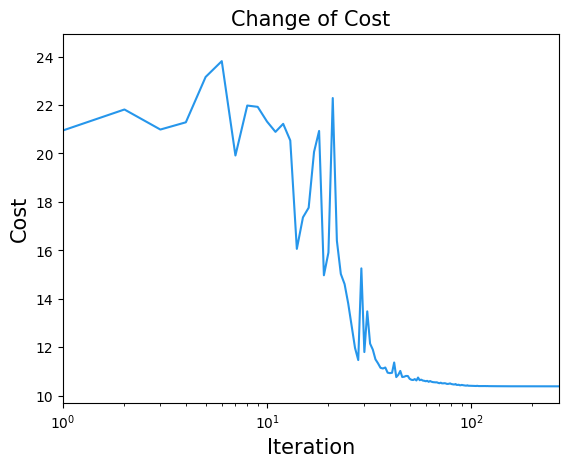

In [48]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

Now, let's run the Optimized paremeter on qiskit `StatevectorSampler`.

In [49]:
# Run Optimized QAOA circuit
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=1000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]

## Evaluating the Results

From the job counts obtained earlier, we can transfer them to a sampleset by `qaoa_converter.decode`.
The sampleset can select only the feasible solutions and then we examine the distribution of the objective function values.


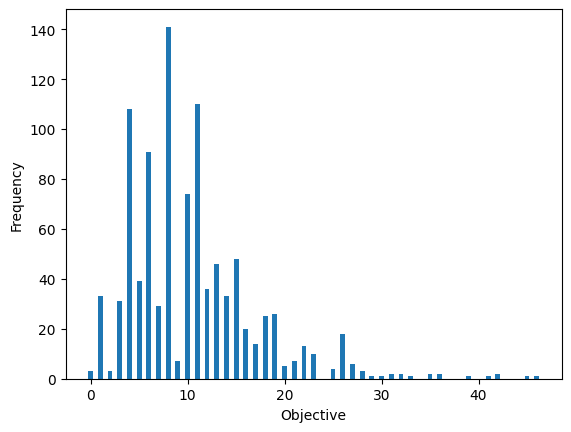

In [51]:
from collections import defaultdict
import matplotlib.pyplot as plt

sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])

# Initialize a dictionary to accumulate occurrences for each energy value
frequencies = defaultdict(int)

# Define the precision to which you want to round the energy values
for entry in sampleset.raw.objectives.entries:
    energy = round(entry.value, ndigits = 3)  
    frequencies[energy] += len(entry.ids)


plt.bar(frequencies.keys(), frequencies.values(), width=0.5)
plt.xlabel('Objective')
plt.ylabel('Frequency')
plt.show()

## Plotting the Solution

From the obtained results, we select one solution that minimizes the objective function value and plot it. (The orange vertices are the vertices included in the vertex cover.)


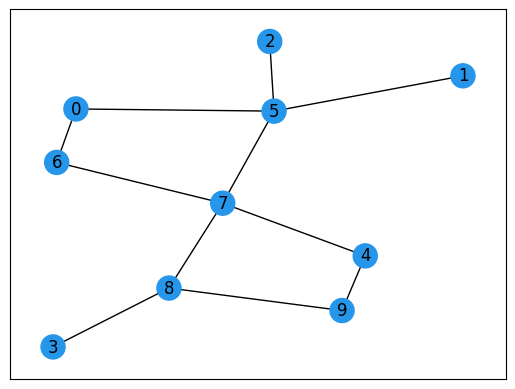

In [54]:
def plot_graph_coloring(graph: nx.Graph, sampleset: ommx.v1.SampleSet):
    # extract feasible solution
    best_sol = sampleset.best_feasible_unrelaxed()
    # initialize vertex color list
    node_colors = ["#2696EB"] * instance_data["V"]
    # set vertex color
    x_value = best_sol.extract_decision_variables("x")
    for t, v in x_value.items():
        if v == 1:
            node_colors[t[0]] = "#EA9b26"
    # make figure
    nx.draw_networkx(graph, node_color=node_colors, pos=positions, with_labels=True)
    plt.show()


plot_graph_coloring(G, sampleset)

Indeed, we can see that a vertex cover has been obtained.